In [1]:
import sys
sys.path.insert(1, '../')  # to load from any submodule in the repo

from utils import readOBJ as reader
from utils import dpcrUtils as utils
from utils import generator
from utils.ranger2020 import Ranger

#from models import predictor_bn, predictor_dp

import numpy as np
import scipy as sp
import scipy.optimize
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial
import time
import itertools
import torch
from torch.optim.lr_scheduler import StepLR, MultiplicativeLR
import copy 

device = torch.device("cuda")

print('Using GPU : ' + str(torch.cuda.current_device()) + ' from ' + str(torch.cuda.device_count()) + ' devices')

Using GPU : 0 from 1 devices


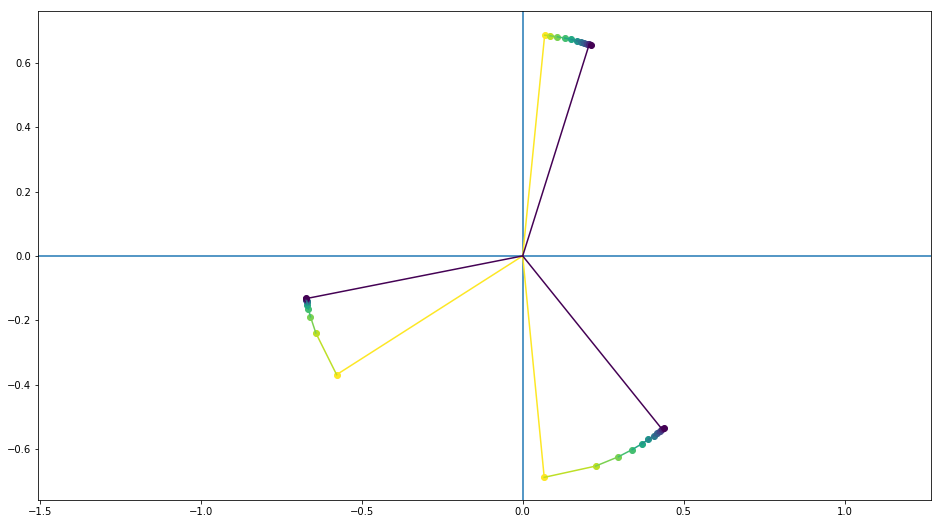

In [2]:
def getTarget(y):
    
    y = y.clone().detach().requires_grad_(True)
    
    y_norm = torch.sqrt(torch.sum(torch.square(y), dim=-1))
    y_n = y / y_norm.unsqueeze(-1)

    yy = 2 * torch.matmul(y_n, y_n.transpose(-2, -1))     # (N, N)
    y2 = torch.sum(y_n**2, dim=-1, keepdim=True)       # (N, 1)

    #print("yy size:", yy.size())
    #print("y2 size:", y2.size())

    # internal directions
    dir_yy = y_n[:,None,:] - y_n[None, :, :] # (N, N, d)
    #print("dir_yy size:", dir_yy.size())

    # calculate spring force by using inner distances (of normed input vectors)
    Sf_yy = torch.exp(-(y2 - yy + y2.transpose(-2, -1))) # (N, N)
    #print("Sf_yy size:", Sf_yy.size())

    # calculate displacement
    Dp_yy = torch.sum(dir_yy * Sf_yy[:,:,None], dim=-2).squeeze(-2) # (N, d)
    #print("Dp_yy size:", Dp_yy.size())

    # calculate target and norm to same length as y
    T_y = y_n + Dp_yy
    T_y = T_y / torch.sqrt(torch.sum(torch.square(T_y), dim=-1))[:,None]
    T_y = T_y * y_norm.unsqueeze(-1)
    
    # calculate difference between target and input
    loss_function = torch.nn.MSELoss(reduction='mean')
    loss = loss_function(y, T_y)
    #print (loss.item())
    loss.backward()
    
    #diff = torch.sqrt(torch.sum(torch.square(T_y - y), dim=-1))[:,None]
    #print (torch.sum(diff).item())
    #torch.sum(diff).backward()
    
    return T_y
    #return y - y.grad

plt.figure(figsize=(16,9))
plt.axis('equal')

plt.axhline(y=0)
plt.axvline(x=0)

N = 10

cmap = matplotlib.cm.get_cmap('viridis')

y = torch.randn((3,2)) # (N, d)

y_numpy = y.detach().numpy()
plt.scatter(y_numpy[:,0], y_numpy[:,1], color=cmap(1.0))

for j in range(y_numpy.shape[0]):
    plt.plot([0, y_numpy[j, 0]], [0, y_numpy[j,1]], color=cmap(1.0))

for i in range(N):
    
    t = getTarget(y)
    y_numpy = y.detach().numpy()
    t_numpy = t.detach().numpy()
    
    for j in range(t_numpy.shape[0]):
        plt.plot([t_numpy[j,0], y_numpy[j,0]], [t_numpy[j,1], y_numpy[j,1]], color=cmap(1-(i+1)/N))

    plt.scatter(t_numpy[:,0], t_numpy[:,1], color=cmap(1-(i+1)/N), label=('iter ' + str(i)))
    
    y = t
    y.grad = None
    
for j in range(y_numpy.shape[0]):
    plt.plot([0, y_numpy[j, 0]], [0, y_numpy[j,1]], color=cmap(0.0))
    
#plt.legend()